In [3]:
!pip install imbalanced-learn
!pip install seaborn


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [4]:
import h5py
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from tensorflow.keras.applications.nasnet import NASNetMobile, preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

In [5]:
read_data = "/kaggle/input/idd-dataset-h5/idd_dataset.h5"
with h5py.File(read_data, 'r') as hf:
    image = hf['images'][:]
    label = hf['labels'][:]
    valid_indices = [i for i, lbl in enumerate(label) if lbl != b'train']

    images = image[valid_indices]
    labels = label[valid_indices]

In [6]:
print('Total number of images: ',len(images))
print('Total number of labels: ',len(labels))

Total number of images:  18142
Total number of labels:  18142


In [7]:
unique_classes, class_counts = np.unique(labels, return_counts=True)
for class_label, count in zip(unique_classes, class_counts):
    print(f"Class {class_label}: {count} samples")

Class b'autorickshaw': 1565 samples
Class b'bicycle': 61 samples
Class b'bus': 1724 samples
Class b'car': 8164 samples
Class b'caravan': 50 samples
Class b'motorcycle': 4238 samples
Class b'truck': 2340 samples


In [8]:
resized_images = [Image.fromarray((image * 255).astype(np.uint8)).resize((224, 224)) for image in images]
resized_images = np.array([preprocess_input(np.array(image)) for image in resized_images])

In [9]:
threshold_low_samples = 2340

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
label_mapping = {i: label for i, label in enumerate(label_encoder.classes_)}

flattened_images_reshaped = np.array([img.flatten() for img in resized_images])
num_samples, num_features = flattened_images_reshaped.shape

oversampled_images = []
oversampled_labels = []

to_sample_images = []
to_sample_labels = []

unique_classes, class_counts = np.unique(encoded_labels, return_counts=True)

for class_label, count in zip(unique_classes, class_counts):
    class_indices = np.where(encoded_labels == class_label)[0]
    
    if count <= threshold_low_samples:
        to_sample_images.extend(flattened_images_reshaped[class_indices])
        to_sample_labels.extend(encoded_labels[class_indices])
    else:
        num_samples_to_keep = threshold_low_samples
            
        indices_to_keep = np.random.choice(class_indices, size=num_samples_to_keep, replace=False)
        oversampled_images.extend(flattened_images_reshaped[indices_to_keep])
        oversampled_labels.extend(encoded_labels[indices_to_keep])

if len(to_sample_images) >= 3:
    smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=2)
    oversampled_class_images, oversampled_class_labels = smote.fit_resample(to_sample_images, to_sample_labels)

    oversampled_images.extend(oversampled_class_images)
    oversampled_labels.extend(oversampled_class_labels)

In [10]:
original_images = np.array(oversampled_images).reshape(-1, 224,224,3)
print('Total number of sampled images: ',len(original_images))
print('Total number of sampled labels: ',len(oversampled_labels))

Total number of sampled images:  16380
Total number of sampled labels:  16380


In [11]:
num_classes = len(np.unique(oversampled_labels))
print('Number of classes',num_classes)

Number of classes 7


In [12]:
labels = to_categorical(encoded_labels, num_classes)
unique_labels_set = set(tuple(label) for label in labels)
for unique_label in unique_labels_list:
    print(unique_label)

[0. 1.]


In [13]:
base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.layers[-1].output

x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
k = 3
epochs = 3
batch_size = 32
kf = KFold(n_splits=k, shuffle=True)

accuracy_values = []
precision_values = []
recall_values = []
f1_score_values = []

confusion_matrices = []
all_true_labels = []
all_pred_labels = []
model_history = []

for fold, (train_index, test_index) in enumerate(kf.split(original_images), 1):
    print("Fold:", fold)
    X_train_fold, X_test_fold = original_images[train_index], original_images[test_index]
    y_train_fold, y_test_fold = labels[train_index], labels[test_index]

    history = model.fit(X_train_fold, y_train_fold, epochs=epochs, batch_size=batch_size)

    y_pred = model.predict(X_test_fold)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_test_fold, axis=1)

    
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    report = classification_report(y_true_labels, y_pred_labels, output_dict=True)
    
    confusion_matrices.append(cm)
    accuracy_values.append(report['accuracy'])
    precision_values.append(report['weighted avg']['precision'])
    recall_values.append(report['weighted avg']['recall'])
    f1_score_values.append(report['weighted avg']['f1-score'])

    all_true_labels.extend(y_true_labels)
    all_pred_labels.extend(y_pred)
    model_history.append(history)
    
avg_accuracy = np.mean(accuracy_values)
avg_weighted_precision = np.mean(precision_values)
avg_weighted_recall = np.mean(recall_values)
avg_weighted_f1_score = np.mean(f1_score_values)

print('Average accuracy:', avg_accuracy)
print('Average weighted precision:', avg_weighted_precision)
print('Average weighted recall:', avg_weighted_recall)
print('Average weighted f1 score:', avg_weighted_f1_score)

Fold: 1
Epoch 1/3
342/342 [==============================] - 126s 199ms/step - loss: 0.9792 - accuracy: 0.6282
Epoch 2/3
342/342 [==============================] - 67s 196ms/step - loss: 0.5766 - accuracy: 0.7854
Epoch 3/3
171/171 [==============================] - 37s 191ms/step
Fold: 2
Epoch 1/3
342/342 [==============================] - 66s 194ms/step - loss: 0.4175 - accuracy: 0.8555
Epoch 2/3
342/342 [==============================] - 67s 195ms/step - loss: 0.3512 - accuracy: 0.8761
Epoch 3/3
171/171 [==============================] - 32s 185ms/step
Fold: 3
Epoch 1/3
342/342 [==============================] - 67s 196ms/step - loss: 0.2704 - accuracy: 0.9065
Epoch 2/3
342/342 [==============================] - 67s 197ms/step - loss: 0.2397 - accuracy: 0.9193
Epoch 3/3
171/171 [==============================] - 32s 186ms/step
Average accuracy: 0.9126373626373626
Average weighted precision: 0.9148011562566459
Average weighted recall: 0.9126373626373626
Average weighted f1 score: 0.91

In [15]:
all_pred_labels = np.array(all_pred_labels)
all_true_labels = np.array(all_true_labels)
n_classes = len(np.unique(all_true_labels))
all_true_labels_binarized = label_binarize(all_true_labels, classes=range(n_classes))
true = all_true_labels_binarized.ravel()
pred = all_pred_labels.ravel()

In [16]:
roc_values = pd.DataFrame({
    'True_Class': true,
    'Pred_Class': pred,
})

roc_values.to_csv('/kaggle/working/IDD_NASNetMobile_ROC.csv', index=False)

In [17]:
learning_curves = pd.DataFrame({
    'Precision': precision_values,
    'Recall': recall_values,
    'F1_score': f1_score_values,
})

learning_curves.to_csv('/kaggle/working/IDD_NASNetMobile_Learning.csv', index=False)

In [18]:
history_values = pd.DataFrame({
    'History': model_history
})

history_values.to_csv('/kaggle/working/IDD_NASNetMobile_History.csv', index=False)

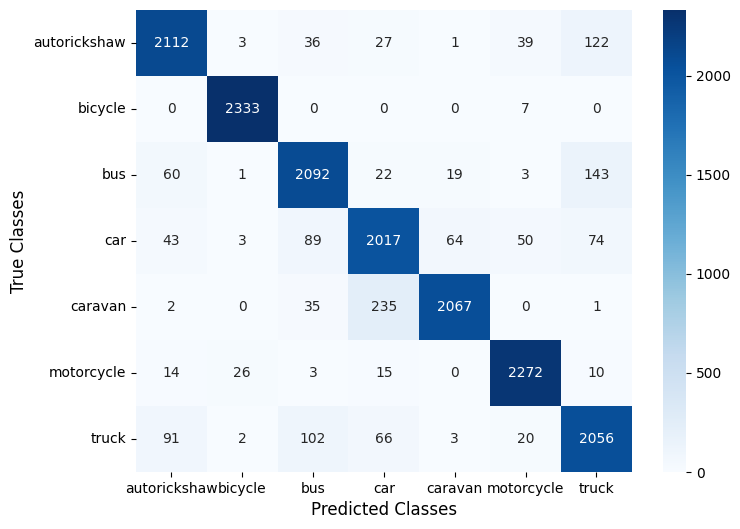

In [19]:
combined_conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

for fold, cm in enumerate(confusion_matrices, 1):
    combined_conf_matrix += cm

conf_matrix_labels = [label_mapping[i] for i in range(len(label_mapping))]
conf_matrix_labels = [label.decode('utf-8')[0:] for label in conf_matrix_labels]

num_labels = len(conf_matrix_labels)
fig_width = min(max(8, num_labels * 0.5), 12)
fig_height = max(6, num_labels * 0.4)

plt.figure(figsize=(fig_width, fig_height))
plt.rcParams['figure.dpi'] = 300

sns.heatmap(combined_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=conf_matrix_labels, yticklabels=conf_matrix_labels)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.xlabel("Predicted Classes", fontsize=12)
plt.ylabel("True Classes", fontsize=12)
plt.savefig('/kaggle/working/confusion_matrix1-IDD_NASNetMobile.png', dpi=300, bbox_inches='tight')
plt.show()

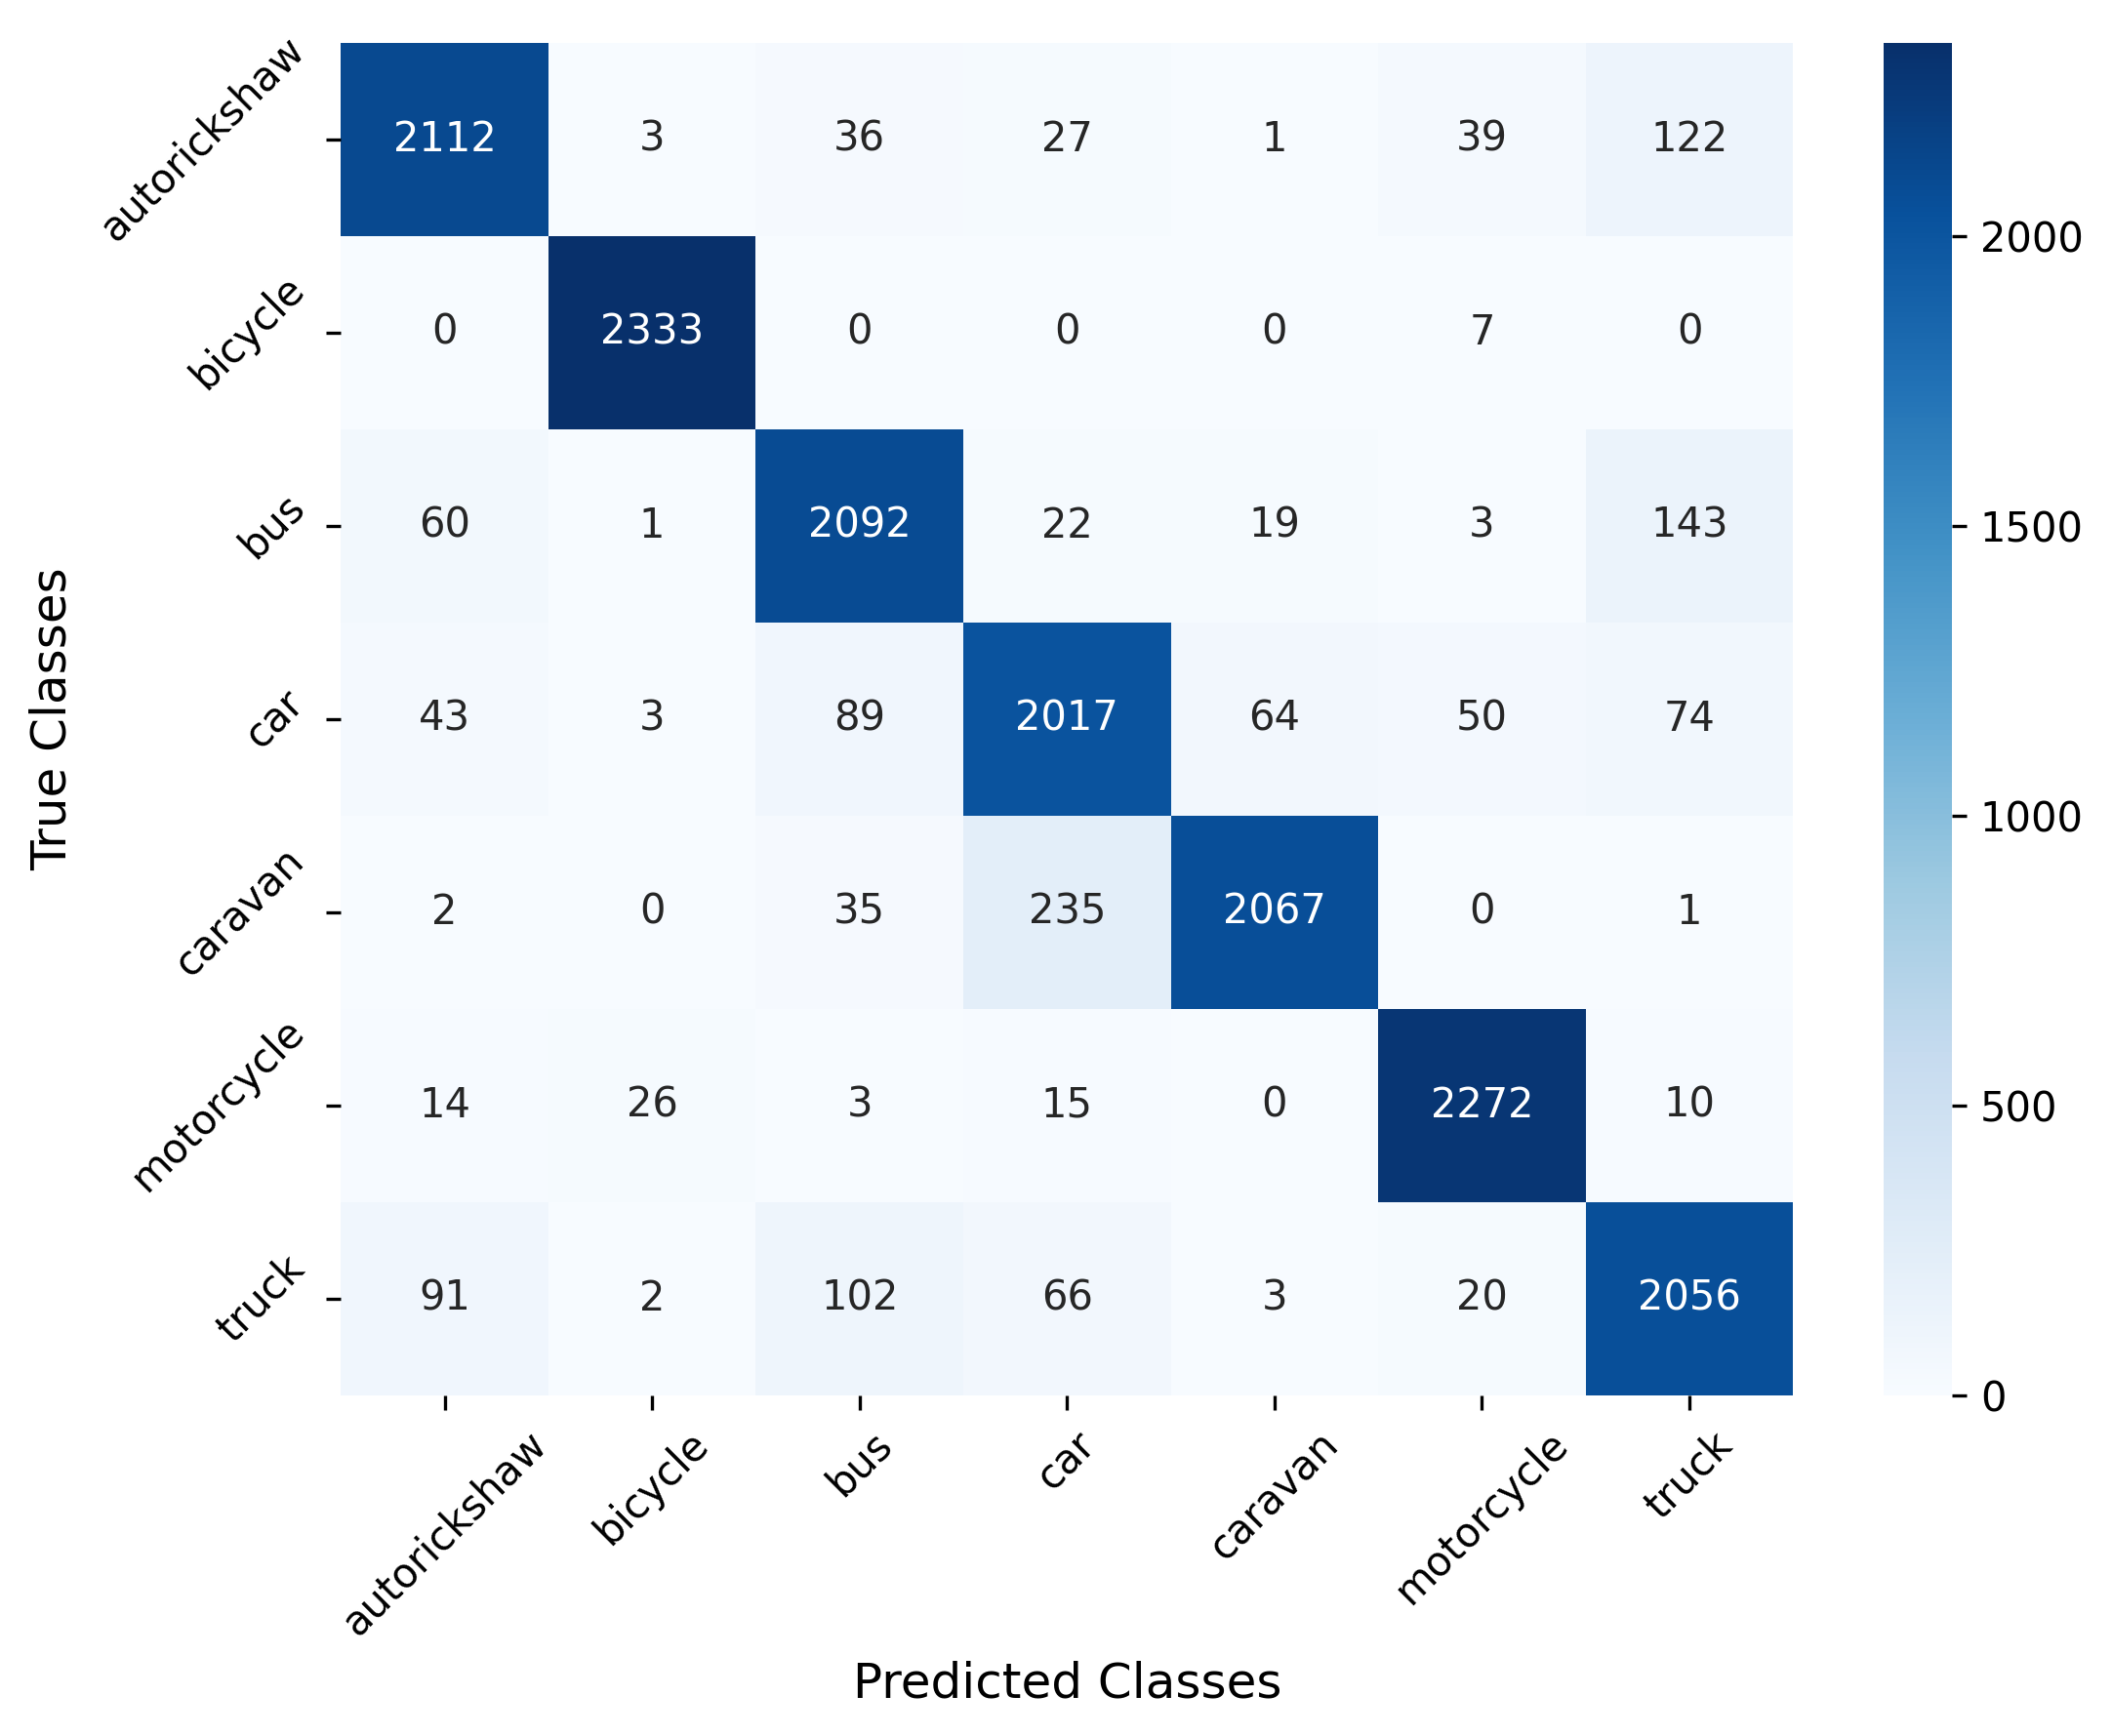

In [20]:
conf_matrix_labels = [label_mapping[i] for i in range(len(label_mapping))]
conf_matrix_labels = [label.decode('utf-8')[0:] for label in conf_matrix_labels]

num_labels = len(conf_matrix_labels)
fig_width = min(max(8, num_labels * 0.5), 12)
fig_height = max(6, num_labels * 0.4)

plt.figure(figsize=(fig_width, fig_height))
plt.rcParams['figure.dpi'] = 300

sns.heatmap(combined_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=conf_matrix_labels, yticklabels=conf_matrix_labels)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(rotation=45, fontsize=10)
plt.xlabel("Predicted Classes", fontsize=12)
plt.ylabel("True Classes", fontsize=12)
plt.savefig('/kaggle/working/confusion_matrix2-IDD_NASNetMobile.png', dpi=300, bbox_inches='tight')
plt.show()